<a href="https://colab.research.google.com/github/alexandrumeterez/ai_notebooks/blob/master/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models import vgg19
from torchvision import transforms
from PIL import Image
import numpy as np
import torch.optim as optim
import os
from IPython.display import display # to display images

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {DEVICE}')

Using cuda


In [0]:
# Load images
IMAGES_DIR = 'images'
CONTENT_IMAGE_NAME = 'dancing.jpg'
STYLE_IMAGE_NAME = 'starrynight.jpg'

def load_image(image_path):
    img = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize((400, 400)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    out = preprocess(img).unsqueeze(0)
    return out

content_img = load_image(os.path.join(IMAGES_DIR, CONTENT_IMAGE_NAME)).to(DEVICE)
style_img = load_image(os.path.join(IMAGES_DIR, STYLE_IMAGE_NAME)).to(DEVICE)

In [14]:
# Load network
cnn = vgg19(pretrained=True)
cnn.eval().to(DEVICE)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [0]:
# Create content loss
def content_loss(content, target):
    return F.mse_loss(content, target)

In [0]:
# Create style loss
def gram_matrix(layer):
    _, n_filters, h, w = layer.size()
    tensor = layer.view(n_filters, h * w)
    G_mat = torch.mm(tensor, tensor.t())

    return G_mat

def style_loss(style, target):
    _, n_filters, h, w = style.size()

    return F.mse_loss(gram_matrix(style), gram_matrix(target)) / (n_filters * h * w)

In [0]:
for param in cnn.parameters():
  param.requires_grad_(False)
# From paper: change all MaxPool2D layers to AvgPool2D
# TODO
for i, layer in enumerate(cnn.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        cnn.features[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

In [0]:
def get_features(image, model, layers=None):
    assert layers is not None, 'Please add a layers array'
    # Get features for each layer in layers from model(image)
    
    features = {}
    
    x = image
    for name, layer in enumerate(model.features):
        x = layer(x) # Compute layer(x)
        if name in layers: # If we want this layer, then save its features
            features[name] = x
    return features

In [0]:
CONTENT_LAYERS = [7]
STYLE_LAYERS = [0, 2, 5, 7, 10]
STYLE_LAYERS_WEIGHTS = [0.75, 0.5, 0.5, 0.2, 0.2, 0.2]
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 1e6

In [0]:
# Generate target image as white noise (or same as content image)
# target_img = torch.randn_like(content_img).requires_grad_(True).to(DEVICE)
target_img = content_img.clone().requires_grad_(True).to(DEVICE)

In [0]:
optimizer = optim.Adam([target_img], lr=0.01)

In [22]:
N_EPOCHS = 100
content_fts = get_features(content_img, cnn, CONTENT_LAYERS)[7]
style_fts = get_features(style_img, cnn, STYLE_LAYERS)

for i in range(N_EPOCHS):
    optimizer.zero_grad()

    # Get target features
    target_content_fts = get_features(target_img, cnn, CONTENT_LAYERS)[7]
    target_style_fts = get_features(target_img, cnn, STYLE_LAYERS)

    # Compute content loss
    _content_loss = content_loss(content_fts, target_content_fts)

    # Compute style loss across all style layers
    _style_loss = 0
    for layer_idx, layer in enumerate(STYLE_LAYERS):
        style_layer = style_fts[layer]
        target_style_layer = target_style_fts[layer]

        layer_style_loss = style_loss(style_layer, target_style_layer)
        _style_loss += STYLE_LAYERS_WEIGHTS[layer_idx] * layer_style_loss
    total_loss = CONTENT_WEIGHT * _content_loss + STYLE_WEIGHT * _style_loss

    print(f'Total loss: {total_loss:.4f}, Content loss: {_content_loss:.4f}, Style loss: {_style_loss:.4f}')

    total_loss.backward(retain_graph=True)
    optimizer.step()

Total loss: 2320373504.0000, Content loss: 0.0000, Style loss: 2320.3735
Total loss: 2285810432.0000, Content loss: 0.0115, Style loss: 2285.8105
Total loss: 2246962432.0000, Content loss: 0.0403, Style loss: 2246.9624
Total loss: 2204192512.0000, Content loss: 0.0808, Style loss: 2204.1926
Total loss: 2157851904.0000, Content loss: 0.1292, Style loss: 2157.8518
Total loss: 2108254208.0000, Content loss: 0.1832, Style loss: 2108.2542
Total loss: 2055758848.0000, Content loss: 0.2412, Style loss: 2055.7588
Total loss: 2000734464.0000, Content loss: 0.3026, Style loss: 2000.7345
Total loss: 1943621888.0000, Content loss: 0.3666, Style loss: 1943.6219
Total loss: 1884882176.0000, Content loss: 0.4325, Style loss: 1884.8822
Total loss: 1824975616.0000, Content loss: 0.5000, Style loss: 1824.9756
Total loss: 1764350720.0000, Content loss: 0.5686, Style loss: 1764.3507
Total loss: 1703406208.0000, Content loss: 0.6382, Style loss: 1703.4062
Total loss: 1642473216.0000, Content loss: 0.7085, 

(-0.5, 399.5, 399.5, -0.5)

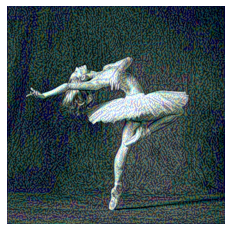

In [23]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array(
    (0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image
out = im_convert(target_img)
fig = plt.figure()
plt.imshow(out)
plt.axis('off')